# Laptop Price Prediction Project

This notebook follows a full ML workflow to predict laptop prices from their specifications. It uses your uploaded dataset.

## 0. Environment Setup

In [25]:

# Core
import pandas as pd
import numpy as np
import re, math, joblib

# Visualization
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
print('Ready!')


Ready!


## 1. Data Ingestion

In [26]:

# Path to your uploaded CSV (already in this environment). If running locally, change to your local path.
DATA_PATH = "laptop_price - dataset.csv"

df = pd.read_csv(DATA_PATH)
# Clean column names (remove line-breaks, fix units)
df.columns = [c.strip().replace('\n',' ').replace('  ',' ').replace('(GB)','GB').replace('(kg)','kg') for c in df.columns]

print(df.shape)
df.head()


(1275, 15)


,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM GB,Memory,GPU_Company,GPU_Type,OpSys,Weight kg,Price (Euro)
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,macOS,1.37,1803.60


In [27]:

# Basic structure checks
print('Columns:', df.columns.tolist())
print('\nDtypes:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isna().sum())
print('\nDuplicate rows:', df.duplicated().sum())


Columns: ['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'CPU_Company', 'CPU_Type', 'CPU_Frequency (GHz)', 'RAM GB', 'Memory', 'GPU_Company', 'GPU_Type', 'OpSys', 'Weight kg', 'Price (Euro)']

Dtypes:
Company                 object
Product                 object
TypeName                object
Inches                 float64
ScreenResolution        object
CPU_Company             object
CPU_Type                object
CPU_Frequency (GHz)    float64
RAM GB                   int64
Memory                  object
GPU_Company             object
GPU_Type                object
OpSys                   object
Weight kg              float64
Price (Euro)           float64
dtype: object

Missing values per column:
Company                0
Product                0
TypeName               0
Inches                 0
ScreenResolution       0
CPU_Company            0
CPU_Type               0
CPU_Frequency (GHz)    0
RAM GB                 0
Memory                 0
GPU_Company            0


## 2. Data Understanding and Exploration (EDA)

In [28]:

# Identify common columns (robust to slight naming differences)
def find_col(candidates):
    for c in candidates:
        for col in df.columns:
            if c.lower() == col.lower():
                return col
    return None

c_Company = find_col(["Company"])
c_Product = find_col(["Product"])
c_TypeName = find_col(["TypeName", "Type"])
c_Inches = find_col(["Inches", "Screen Size", "ScreenSize"])
c_ScreenResolution = find_col(["ScreenResolution", "Resolution"])
c_CPU_Company = find_col(["CPU_Company", "CPU Company", "CPUCompany"])
c_CPU_Type = find_col(["CPU_Type", "CPU Type", "CPU"])
c_CPU_Frequency = find_col(["CPU_Frequency", "CPU Frequency", "CPU_Freq", "CPU Mhz", "CPU GHz"])
c_RAM = find_col(["RAM (GB)", "RAM", "RAMGB"])
c_Memory = find_col(["Memory", "Storage"])
c_GPU_Company = find_col(["GPU_Company", "GPU Company", "GPUCompany"])
c_GPU_Type = find_col(["GPU_Type", "GPU Type", "GPU"])
c_OpSys = find_col(["OpSys", "OS", "Operating System"])
c_Weight = find_col(["Weight (kg)", "Weight", "Weightkg"])
c_Price = [c for c in df.columns if 'price' in c.lower()][0]

key_cols = [c_Company, c_Product, c_TypeName, c_Inches, c_ScreenResolution, c_CPU_Company, c_CPU_Type, c_CPU_Frequency, c_RAM, c_Memory, c_GPU_Company, c_GPU_Type, c_OpSys, c_Weight, c_Price]
print('Mapped columns:', key_cols)


Mapped columns: ['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'CPU_Company', 'CPU_Type', None, None, 'Memory', 'GPU_Company', 'GPU_Type', 'OpSys', None, 'Price (Euro)']


### 2.1 Univariate (Numerical)

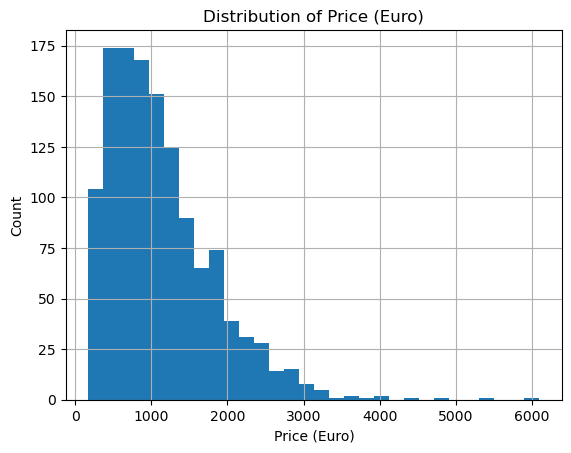

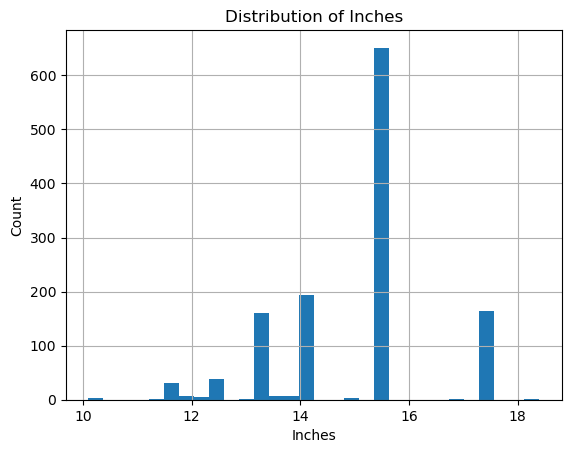

In [29]:

num_cols = [c for c in [c_Price, c_Inches, c_RAM, c_CPU_Frequency, c_Weight] if c is not None and c in df.columns]

# Cast numerics safely
for c in [c_Inches, c_CPU_Frequency, c_RAM, c_Weight, c_Price]:
    if c is not None and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Histograms (one plot at a time, matplotlib only, no custom colors)
for c in num_cols:
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()


### 2.2 Univariate (Categorical)

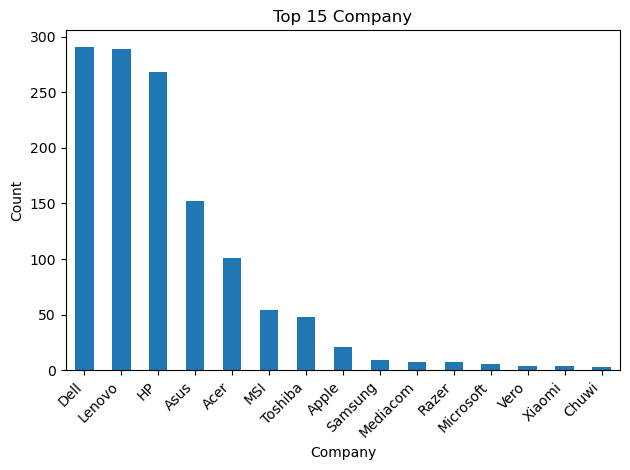

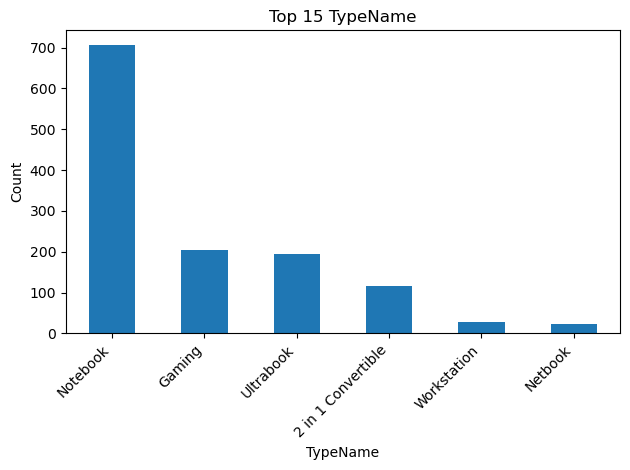

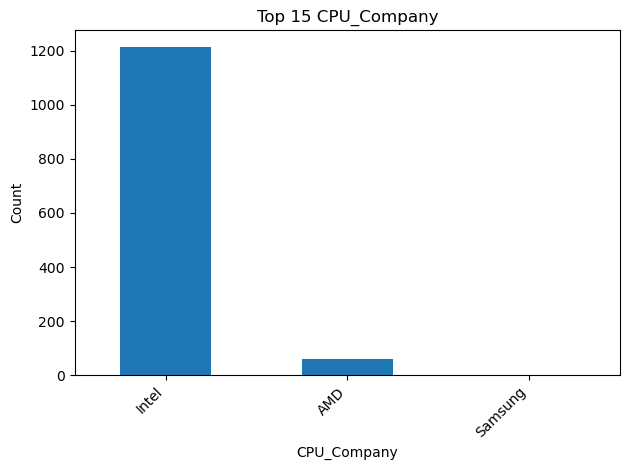

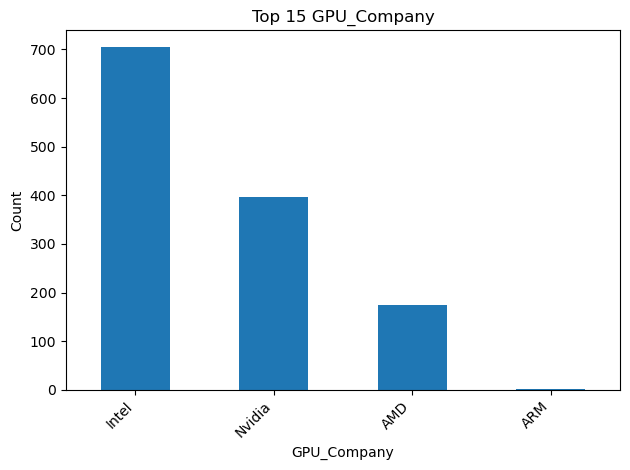

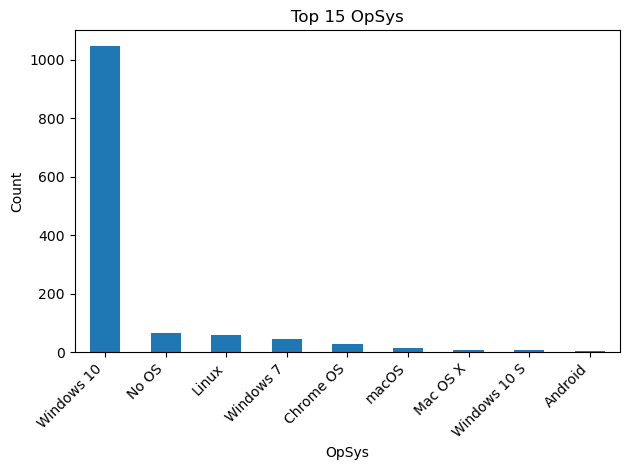

In [30]:

cat_cols = [c for c in [c_Company, c_TypeName, c_CPU_Company, c_GPU_Company, c_OpSys] if c is not None and c in df.columns]

for c in cat_cols:
    plt.figure()
    df[c].value_counts().head(15).plot(kind='bar')
    plt.title(f"Top 15 {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### 2.3 Bivariate

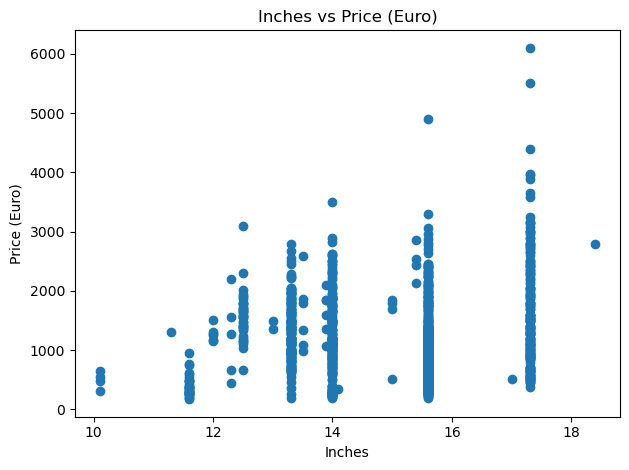

<Figure size 640x480 with 0 Axes>

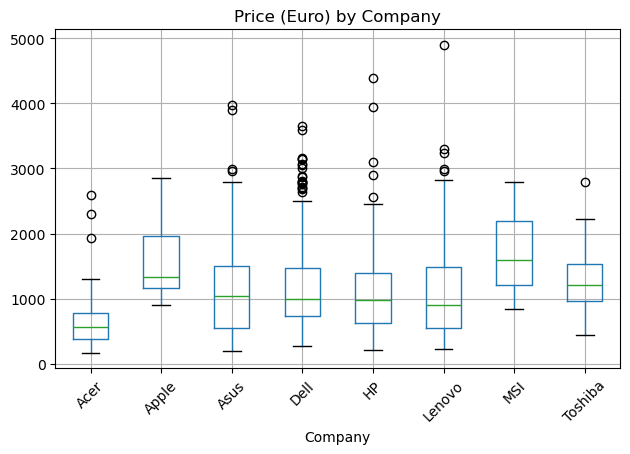

<Figure size 640x480 with 0 Axes>

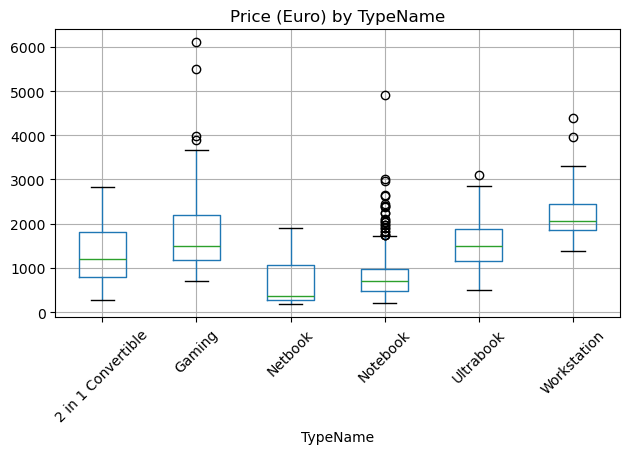

<Figure size 640x480 with 0 Axes>

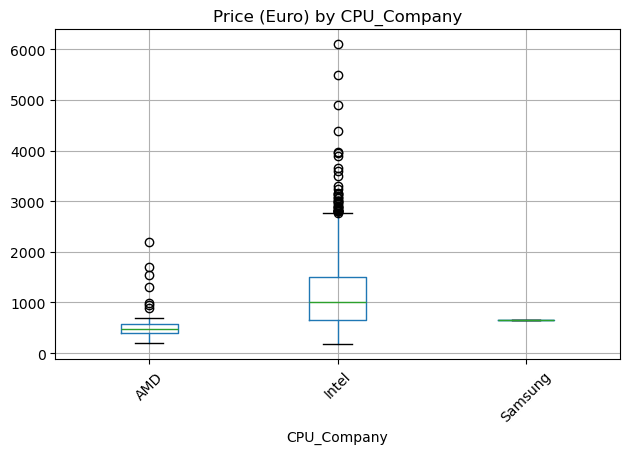

<Figure size 640x480 with 0 Axes>

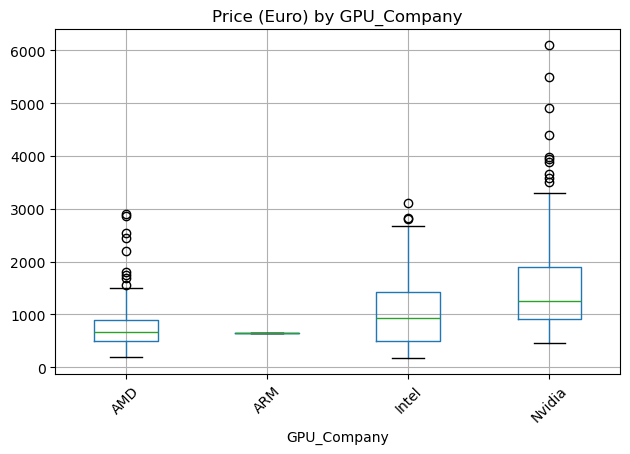

In [31]:

# Scatter vs target for numeric
for c in [c_Inches, c_RAM, c_CPU_Frequency, c_Weight]:
    if c is None or c not in df.columns:
        continue
    plt.figure()
    plt.scatter(df[c], df[c_Price])
    plt.title(f"{c} vs {c_Price}")
    plt.xlabel(c); plt.ylabel(c_Price)
    plt.tight_layout()
    plt.show()

# Boxplots of price by top categories
for c in [c_Company, c_TypeName, c_CPU_Company, c_GPU_Company]:
    if c is None or c not in df.columns:
        continue
    top_vals = df[c].value_counts().head(8).index
    plt.figure()
    df[df[c].isin(top_vals)].boxplot(column=c_Price, by=c, rot=45)
    plt.title(f"{c_Price} by {c}")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()


## 3. Data Cleaning & Feature Engineering

In [32]:

# Parsing helpers
def parse_memory_column(mem_str):
    if pd.isna(mem_str):
        return np.nan, np.nan
    s = str(mem_str).upper().replace(" ", "")
    s = s.replace("TB", "000GB")  # 1TB = 1000GB here
    parts = s.split('+')
    ssd_gb = 0
    hdd_gb = 0
    for p in parts:
        m = re.search(r'(\d+)GB', p)
        size = int(m.group(1)) if m else 0
        if "SSD" in p or "FLASH" in p or "EMMC" in p:
            ssd_gb += size
        elif "HDD" in p or "HYBRID" in p or "SSH" in p:
            hdd_gb += size
        else:
            # assume SSD-like if type not specified
            ssd_gb += size
    ssd_gb = np.nan if ssd_gb == 0 else ssd_gb
    hdd_gb = np.nan if hdd_gb == 0 else hdd_gb
    return ssd_gb, hdd_gb

def extract_resolution_xy(res_str):
    if pd.isna(res_str):
        return np.nan, np.nan
    m = re.search(r'(\d+)\s*[xX]\s*(\d+)', str(res_str))
    if m:
        return int(m.group(1)), int(m.group(2))
    return np.nan, np.nan

def compute_ppi(width, height, inches):
    try:
        if np.isfinite(width) and np.isfinite(height) and np.isfinite(inches) and inches > 0:
            return math.sqrt(width**2 + height**2) / inches
    except Exception:
        pass
    return np.nan

# Memory features
if c_Memory is not None:
    parsed = df[c_Memory].apply(parse_memory_column)
    df['SSD_GB'] = [t[0] for t in parsed]
    df['HDD_GB'] = [t[1] for t in parsed]

# Resolution -> PPI
if c_ScreenResolution is not None and c_Inches is not None:
    res = df[c_ScreenResolution].apply(extract_resolution_xy)
    df['Res_Width'] = [t[0] for t in res]
    df['Res_Height'] = [t[1] for t in res]
    df['PPI'] = [compute_ppi(w, h, inc) for w, h, inc in zip(df['Res_Width'], df['Res_Height'], df[c_Inches])]

# Drop duplicates
before = len(df)
df = df.drop_duplicates()
print("Dropped duplicates:", before - len(df))

df[[c for c in df.columns if c in [c_Company, c_Product, c_TypeName, c_Inches, c_ScreenResolution, 'Res_Width','Res_Height','PPI', c_CPU_Company, c_CPU_Type, c_CPU_Frequency, c_RAM, c_Memory, 'SSD_GB','HDD_GB', c_GPU_Company, c_GPU_Type, c_OpSys, c_Weight, c_Price] if c is not None]].head()


Dropped duplicates: 0


,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,Memory,GPU_Company,GPU_Type,OpSys,Price (Euro),SSD_GB,HDD_GB,Res_Width,Res_Height,PPI
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,128GB SSD,Intel,Iris Plus Graphics 640,macOS,1339.69,128.0,NaN,2560,1600,226.983005
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,128GB Flash Storage,Intel,HD Graphics 6000,macOS,898.94,128.0,NaN,1440,900,127.677940
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,256GB SSD,Intel,HD Graphics 620,No OS,575.00,256.0,NaN,1920,1080,141.211998
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,512GB SSD,AMD,Radeon Pro 455,macOS,2537.45,512.0,NaN,2880,1800,220.534624
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,256GB SSD,Intel,Iris Plus Graphics 650,macOS,1803.60,256.0,NaN,2560,1600,226.983005


## 4. Preprocessing & Split

In [33]:

# Define feature lists
cat_features = [c for c in [c_Company, c_Product, c_TypeName, c_CPU_Company, c_CPU_Type, c_GPU_Company, c_GPU_Type, c_OpSys] if c is not None]
num_features = [c for c in [c_Inches, c_CPU_Frequency, c_RAM, c_Weight, 'Res_Width','Res_Height','PPI','SSD_GB','HDD_GB'] if c in df.columns]

# Target
target = c_Price

X = df[cat_features + num_features].copy()
y = pd.to_numeric(df[target], errors='coerce')

# Train/Validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (1020, 14)  Test shape: (255, 14)


## 5. Modeling & Evaluation (Baseline)

In [34]:

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=300),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

def evaluate(pipe, X_tr, X_te, y_tr, y_te):
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    r2 = r2_score(y_te, preds)
    mse = mean_squared_error(y_te, preds)
    rmse = math.sqrt(mse)
    return r2, mse, rmse

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    r2, mse, rmse = evaluate(pipe, X_train, X_test, y_train, y_test)
    results.append({"Model": name, "R2": r2, "MSE": mse, "RMSE": rmse})

from IPython.display import display

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
display(results_df)


,Model,R2,MSE,RMSE
2,RandomForest,0.835341,81726.699296,285.878819
3,GradientBoosting,0.813611,92512.296890,304.158342
1,DecisionTree,0.720105,138922.706978,372.723365
0,LinearRegression,-0.474759,731980.933718,855.558843


## 6. Hyperparameter Tuning (Optional)

In [35]:

# RandomForest tuning (quick randomized search)
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", RandomForestRegressor(random_state=42))])
rf_param = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}
rf_search = RandomizedSearchCV(rf_pipe, rf_param, n_iter=15, cv=3, scoring="r2", n_jobs=-1, random_state=42, verbose=1)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
rf_preds = rf_best.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = math.sqrt(rf_mse)
print("Best RF R2:", rf_r2, " RMSE:", rf_rmse)

# GradientBoosting tuning (quick randomized search)
gb_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", GradientBoostingRegressor(random_state=42))])
gb_param = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.6, 0.8, 1.0]
}
gb_search = RandomizedSearchCV(gb_pipe, gb_param, n_iter=15, cv=3, scoring="r2", n_jobs=-1, random_state=42, verbose=1)
gb_search.fit(X_train, y_train)
gb_best = gb_search.best_estimator_
gb_preds = gb_best.predict(X_test)
gb_r2 = r2_score(y_test, gb_preds)
gb_mse = mean_squared_error(y_test, gb_preds)
gb_rmse = math.sqrt(gb_mse)
print("Best GB R2:", gb_r2, " RMSE:", gb_rmse)

best = rf_best if rf_r2 >= gb_r2 else gb_best
print("Selected best model:", "RandomForest" if best is rf_best else "GradientBoosting")


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best RF R2: 0.8695933252041619  RMSE: 254.41296034873776
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best GB R2: 0.8739431487591884  RMSE: 250.13389639296508
Selected best model: GradientBoosting


## 7. Model Interpretation

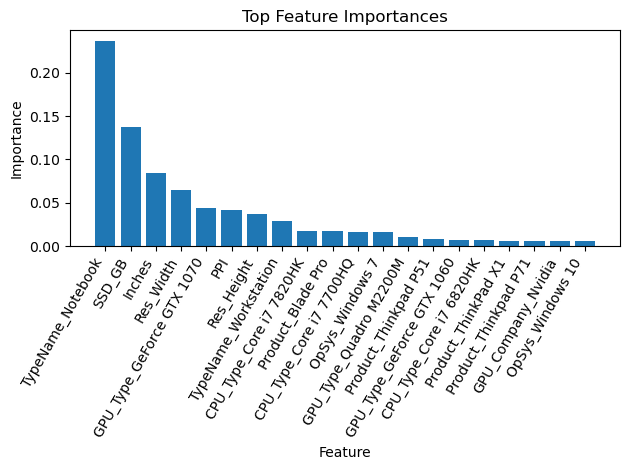

,Feature,Importance
552,TypeName_Notebook,0.237084
4,SSD_GB,0.137053
0,Inches,0.084674
1,Res_Width,0.064604
667,GPU_Type_GeForce GTX 1070,0.043552
3,PPI,0.041191
2,Res_Height,0.036559
554,TypeName_Workstation,0.028908
622,CPU_Type_Core i7 7820HK,0.017033
95,Product_Blade Pro,0.016841


                       Feature  Importance
552          TypeName_Notebook    0.237084
4                       SSD_GB    0.137053
0                       Inches    0.084674
1                    Res_Width    0.064604
667  GPU_Type_GeForce GTX 1070    0.043552
3                          PPI    0.041191
2                   Res_Height    0.036559
554       TypeName_Workstation    0.028908
622    CPU_Type_Core i7 7820HK    0.017033
95           Product_Blade Pro    0.016841
621    CPU_Type_Core i7 7700HQ    0.016659
753            OpSys_Windows 7    0.016238
710     GPU_Type_Quadro M2200M    0.010816
430       Product_Thinkpad P51    0.008287
666  GPU_Type_GeForce GTX 1060    0.007494
614    CPU_Type_Core i7 6820HK    0.007202
423        Product_ThinkPad X1    0.006309
432       Product_Thinkpad P71    0.005846
647         GPU_Company_Nvidia    0.005755
751           OpSys_Windows 10    0.005476


In [45]:

best_est = best  # from tuning above
try:
    mdl = best_est.named_steps["model"]
    if hasattr(mdl, "feature_importances_"):
        pre = best_est.named_steps["preprocess"]
        # Build feature name list
        num_names = [c for c in num_features]
        cat_ohe = pre.named_transformers_["cat"].named_steps["onehot"]
        cat_names = cat_ohe.get_feature_names_out(cat_features).tolist()
        feature_names = num_names + cat_names
        importances = mdl.feature_importances_
        imp_df = pd.DataFrame({"Feature": feature_names[:len(importances)], "Importance": importances}).sort_values(by="Importance", ascending=False).head(20)
        imp_df
        # Plot
        plt.figure()
        plt.bar(imp_df["Feature"], imp_df["Importance"])
        plt.title("Top Feature Importances")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.xticks(rotation=60, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not expose feature_importances_.")
except Exception as e:
    print("Feature importance not available:", e)
from IPython.display import display

imp_df = pd.DataFrame(
    {"Feature": feature_names[:len(importances)], "Importance": importances}
).sort_values(by="Importance", ascending=False).head(20)

display(imp_df)   # ensure nice table
print(imp_df)     # fallback plain text (guarantees you see something)



## 8. Save Artifacts

In [42]:

import os
MODEL_PATH = "laptop_price_model.pkl"
CLEANED_SNAPSHOT_PATH = "laptop_price_cleaned_snapshot.csv"

joblib.dump(best, MODEL_PATH)
df_out = df[cat_features + num_features + [target]].copy()
df_out.to_csv(CLEANED_SNAPSHOT_PATH, index=False)

print("Saved model to:", os.path.abspath(MODEL_PATH))
print("Saved cleaned snapshot to:", os.path.abspath(CLEANED_SNAPSHOT_PATH))


Saved model to: C:\Users\Lakshay\laptop_price_model.pkl
Saved cleaned snapshot to: C:\Users\Lakshay\laptop_price_cleaned_snapshot.csv


## 9. Quick Inference Helper

In [41]:

# Example: predict from a single spec row (edit values as needed)
example = pd.DataFrame([{
    c_Company: "Dell",
    c_Product: "Inspiron X",
    c_TypeName: "Notebook",
    c_Inches: 15.6,
    c_ScreenResolution: "1920x1080",
    c_CPU_Company: "Intel",
    c_CPU_Type: "Core i5",
    c_CPU_Frequency: 2.5,
    c_RAM: 8,
    c_Memory: "256GB SSD + 1TB HDD",
    c_GPU_Company: "Nvidia",
    c_GPU_Type: "GTX 1050",
    c_OpSys: "Windows 10",
    c_Weight: 2.2
}])

# Reuse engineering functions
def _parse_row(row):
    ssd, hdd = parse_memory_column(row[c_Memory]) if c_Memory in row else (np.nan, np.nan)
    w,h = extract_resolution_xy(row[c_ScreenResolution]) if c_ScreenResolution in row else (np.nan, np.nan)
    row['SSD_GB'] = ssd; row['HDD_GB'] = hdd
    row['Res_Width'] = w; row['Res_Height'] = h
    row['PPI'] = compute_ppi(w, h, row[c_Inches])
    return row

example = example.apply(_parse_row, axis=1)

# Align columns & predict
X_cols = [*cat_features, *num_features]
example = example.reindex(columns=X_cols, fill_value=np.nan)

pred_price = best.predict(example)[0]
print("Predicted price (Euro):", round(float(pred_price), 2))


Predicted price (Euro): 868.07
